LSTM model architecture 2:

First working model (previous one didn't produce lyrics correctly) with and Embedding layer, a Bidirectional LSTM layer, a dropout layers to avoid overfitting and a dense layer.



Also includes function that outputs most used words in the Vocabulary.

Has a basic lyric generator that can be improved. Maybe we can create a loss function which favours rhyme or look at creating bars line by line. The problem with this was bars ending in words like 'i' and 'the' as lines were getting cut short.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from google.colab import files
from google.colab import drive
import numpy as np
#@title Import Statements`
!pip install PyGithub

# Package Imports
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from urllib.request import urlopen # The default requests package
import requests # For making GitHub requests
from pprint import pprint # For pretty printing
from pathlib import Path # The Path class

# For the more advanced requests
import base64
import os
import sys
sys.path.append("./PyGithub");
from github import Github
from getpass import getpass


     |████████████████████████████████| 296kB 20.5MB/s 


In [2]:
#@title Function Definitions
# Recursively Import the Data (AUTOMATIC)

def _decode_and_write(file__, path_):
    data = file__.decoded_content
    data = data.decode('utf-8')[1:]
    with open(path_, 'w') as writefile:
        writefile.write(data) 
    data = data.splitlines()
    data_rows = []
    for count, word in enumerate(data):
        if count>0:
            data_rows.append(word.split(','))
    data = pd.DataFrame(data_rows)
    data = data.to_numpy()
    return data


def import_github(path_name="AllLyrics.txt"):
    """
    Function for importing the github file
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()
    print("Importing Github cleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    RAP_DATA = []
    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the Lyrics
            RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
    
    temp_path = Path(path_name)
    if temp_path.is_file(): 
        if os.stat(path_name).st_size == 0:
            write_bool2 = True
        else: 
            write_bool2 = False
    else: 
        write_bool2 = True
    
    if write_bool2: 
        for lyric in RAP_DATA: 
            try:
                with open(path_name, 'w') as writefile: 
                    writefile.write(lyric)
            except: 
                print("Error, file moved/deleted during write")
        print("{} is now up to date!".format(path_name))
    else: 
        print("{} is already up to date!".format(path_name))
    
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 

        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        path = path[title_start + 6:title_start + title_len + 4]

        print("Writing file {} {}".format(counter, path))
        temp_path = Path(path)
        if temp_path.is_file():
            with open(path,'w'): pass # Cheeky way to clear the file if it exists
        
        # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy array 
        data = file_.decoded_content
        data = data.decode('utf-8')[1:]

        with open(path, 'w') as writefile:
            writefile.write(data) 
        print("All files now up to date!")


def update_github(write_bool=False, path_name="AllLyrics.txt"):
    """
    Function for updating the github file, by cleaning the lyrics, optional write to txt file. 
    write_bool: bool
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()

    print("Importing editing csv files...")

    # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy arr
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path 
        path = str(path)
        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len + 4]
        print("Writing file {} {}".format(counter, name))
        if name.lower() == "censors.csv":
            censors = _decode_and_write(file_, path)
        elif name.lower() == "capitals.csv":
            capitals = _decode_and_write(file_, path)
        else: 
            _decode_and_write(file_, path)
    print("All editing csv files are up to date!")

    print("Importing Github uncleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/UNCLEAN", ref=branch)

    RAP_DATA = []
    rap_lyric_names = []

    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('UNCLEAN')
            title_len = path[title_start:].find('.')
            name = path[title_start + 8:title_start + title_len]
            if name[-2:] == 'UC':
                name = name[:-2]
            rap_lyric_names.append(name) 

        # Append the Lyrics
        RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
        
    # Remove the \ufeff at the beginning O(n)
    for count, lyric in enumerate(RAP_DATA): 
        RAP_DATA[count] = lyric[1:]

    # Censor the profanities O(n*m + n*m2) m > m2 xor m2 > m
    for count in range(len(RAP_DATA)): 
        for i in range(len(censors[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(censors[i, 0]), str(censors[i, 1]))
        for i in range(len(capitals[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(capitals[i, 0]), str(capitals[i, 1]))

    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    cleaned_names = []
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 
        print("File {} ".format(counter + 1) + path)
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('CLEAN')
            title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len]
        if name[-2:] == 'CL':
            name = name[:-2]
        cleaned_names.append(name) 

    # ALL OF THE EDITING IS DONE IN THE 'PROTOTYPE BRANCH' to avoid overwriting import changes
    # If the (now cleaned) rap_lyrics name is new (not in cleaned_names), then we want to create that as a new file 
    # If the (now cleaned) rap_lyrics name is NOT new (not in cleaned_names), then we want to update the file
    # print(rap_lyric_names)
    # print(cleaned_names)
    print("Commiting files to github...")
    for counter, new_name in enumerate(rap_lyric_names): 
        if new_name in cleaned_names: 
            duplicate = r_proj_clone.get_contents("RapLyrics/CLEAN/{}CL.txt".format(new_name), ref=branch)
            r_proj_clone.update_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], duplicate.sha, branch=branch)
        else:
            r_proj_clone.create_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], branch=branch)

    if write_bool: 
        print("Writing text file to: {}".format(path_name))
        with open(path_name, 'w') as writefile:
            for lyric in RAP_DATA:
                writefile.write(lyric)

In [3]:
# Import all of Mike's lyrics. PATKEY: 5ae2446bd5828c9e27deb3865118d9e783aa6e15
import_github()

Enter your PAT key ··········
Main Branch: Yes or No? Yes
Importing Github cleaned text files...
AllLyrics.txt is now up to date!
Writing file 0 capitals.csv
All files now up to date!
Writing file 1 censors.csv
All files now up to date!
Writing file 2 censors2.csv
All files now up to date!


In [4]:
Text = open("AllLyrics.txt", "r").read()
# turn text to lower case to reduce vocabulary
Text = Text.lower()
with open("AllLyrics.txt", "r") as f:
    content = f.readlines()
# bars is a list containing each line in dataset in lowercase
bars = [x.strip().lower() for x in content]
stripped_bars = [word.split() for word in bars]
# Vocabulary is a list of all words in the dataset
Vocabulary = ''.join([i for i in Text if not i.isdigit()]).replace("\n"," ").split(' ')

In [5]:
# The numbers of bars in our dataset, 5283
no_of_bars = len(bars)
print(no_of_bars)

5283


In [6]:
# word_count is a function creating a list of words ranked in order of most used
# could think about removing certain words to create more accurate raps as model won't learn well from words used very infrequently
def word_count(lyrics):
  a = {}
  for word in Vocabulary:
    if word in a:
      a[word] += 1
    else:
      a[word] = 1
  return a
word_dict = word_count(Vocabulary)
sort_dict = sorted(word_dict.items(), key = lambda x: x[1], reverse = True)
# Top 20 words
sort_dict1 = sort_dict[:40]

In [7]:
# Need to create dictionary listing the words in alphabetical order so we can assign unique integers to each word
# Neural networks take in integers, not words
words = sorted(list(set(Vocabulary)))
# Create a dictionary whereby we can convert integers into words
word_to_int = { words[i] : i for i in range(len(words))}
# Need to reverse this at the end to reverse numbers back into words
int_to_word = { i : words[i] for i in range(len(words))}

In [8]:
# create a function that converts bars into a sequence of unique integers
def words_to_integers(bar, Vocabulary):
  encode = []
  # Need to strip bar into single list of words within bar
  stripped_bar = [word.split() for word in bar]
  for i in range(no_of_bars):
    seq = []
    seq.append([word_to_int[word] for word in stripped_bar[i]])
    encode.append(seq)

  encode = sum(encode, [])
  return encode

In [9]:
# Number of unique words in our dataset
vocab_size = len(words) + 1
print(vocab_size)

5066


In [10]:
# Define a function that converts sentences into a sequence of corresponding integers
def sentence_to_integer(bar):
    stripped_bar = [word.split() for word in [bar]]
    stripped_bar = sum(stripped_bar, [])
    seq = []
    seq.append([word_to_int[word] for word in stripped_bar])
    seq = sum(seq, [])
    return seq

In [11]:
# Want to convert bars into n-grams of increasing length
# So we start with the first two words and create lists of increasing length after adding the next word
sequences = []
for line in bars:
    token_list = sentence_to_integer(line)
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        sequences.append(n_gram_seq)

In [12]:
# We need to pad each line so that each line is of equal length for our model
# Thus need to find max length of a bar so we can pad all bars to this length
padding_length = max([len(line) for line in sequences])
print(padding_length)

66


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = np.array(pad_sequences(sequences, maxlen = padding_length, padding = 'pre'))
# Remove last word from each line
x_train = sequences[:,:-1]
# Last word is used as the label
y_train = sequences[:,-1]
# one hot encode the the outputs 
y_train = tf.keras.utils.to_categorical(y_train, num_classes = vocab_size)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 512, input_length = padding_length - 1))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 512)           2593792   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5066)              5192650   
Total params: 11,984,842
Trainable params: 11,984,842
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train,validation_split=0.15, epochs = 50, batch_size = 256)

Epoch 1/50
96/96 [==============================] - 60s 304ms/step - loss: 7.0905 - accuracy: 0.0424 - val_loss: 6.4619 - val_accuracy: 0.0470
Epoch 2/50
96/96 [==============================] - 28s 296ms/step - loss: 6.2753 - accuracy: 0.0586 - val_loss: 6.2455 - val_accuracy: 0.0791
Epoch 3/50
96/96 [==============================] - 29s 297ms/step - loss: 5.9568 - accuracy: 0.0868 - val_loss: 6.0027 - val_accuracy: 0.1002
Epoch 4/50
96/96 [==============================] - 29s 300ms/step - loss: 5.4583 - accuracy: 0.1284 - val_loss: 5.8174 - val_accuracy: 0.1356
Epoch 5/50
96/96 [==============================] - 29s 300ms/step - loss: 4.9780 - accuracy: 0.1735 - val_loss: 5.6508 - val_accuracy: 0.1679
Epoch 6/50
96/96 [==============================] - 29s 299ms/step - loss: 4.4997 - accuracy: 0.2154 - val_loss: 5.5413 - val_accuracy: 0.1916
Epoch 7/50
96/96 [==============================] - 29s 299ms/step - loss: 4.0468 - accuracy: 0.2624 - val_loss: 5.4703 - val_accuracy: 0.2144

In [17]:
model.save('/content/drive/MyDrive/lstm-basic-validation2')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lstm-basic-validation2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lstm-basic-validation2/assets


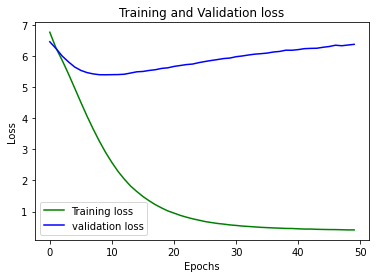

In [18]:
# Plotting a loss curve to see if we need this many epochs
# Looks to still be decreasing slowly
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

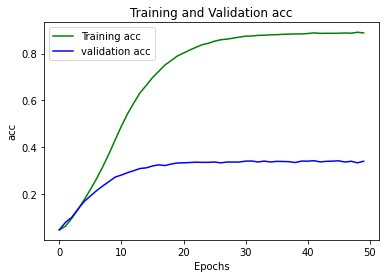

In [20]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(50)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [15]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/lstm-basic-validation2')


In [16]:

# Create a function to generate 'next_words' number of words on top of the seeded bar
def generateraplyrics(next_words):
  seed_text  = random.choice(bars)
  token_list = sentence_to_integer(seed_text)
  token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
  predicted  = new_model.predict_classes(token_list, verbose = 0)
  lyrics = int_to_word[predicted[0]]
  for _ in range(next_words):
      token_list = sentence_to_integer(lyrics)
      token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
      predicted  = new_model.predict_classes(token_list, verbose = 0)
      lyrics += ' ' + int_to_word[predicted[0]]
  return lyrics.capitalize()

In [19]:
# Example of output with 4000 words generated 
for i in range(80):
  print(generateraplyrics(49))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Ninjas bleed just like us believe my pipe bust up in his bed quite mine pass that poop i got to light one ninja you just like to choose a poops til i wanna get witcha can i get witcha can i get witcha can i get witcha can i
With the neighborhood license plates outta state on the back of the pathfinder i dont know i want a frickin fortune dont shoot with the funk ill die for the funk ill die for the funk ill die for the funk ill die for the funk ill die for the
Get high get high get high now now check hot i like to bust on a frickin bath alright with a way to you know that i wanna be on her on and on a dime is so you wanna see a lot of slow singin quick smith locked like
One thousand grams of uncut time the head on the floor check it i dont wanna live no mo to this stroke of poop i got to light one ninja pass that sandwhiches go take my man tooken get down down to the mall ill die for the funk ill
Of ninjaz wanna be wit my d*ck ninja in ya while me and a b***** never been as me as me a 